In [1]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt

import dataset as dd # custom dataset class
import models as md

# so that when you change an imported file, it changes in the notebook
%load_ext autoreload 
%autoreload 2
%matplotlib notebook

In [2]:
do_channel_augmentation = False
epochs_to_train = 100

# use this to train on multiple datasets with data augmentation
#generator_train =  dd.MRImageSequence(scan_numbers=[1, 2, 3, 4], batch_size=10, augment_channels=do_channel_augmentation, augment_images=True)

# use this to train on a single knee (makai)
generator_train =  dd.MRImageSequence(scan_numbers=[1], batch_size=10, augment_channels=do_channel_augmentation)

generator_test = dd.MRImageSequence(scan_numbers=[5], batch_size=10, augment_channels=do_channel_augmentation)

('loading scan ', 1)
('X shape: ', (320, 320, 256, 8))
('y shape: ', (320, 320, 256, 1))
('augment_images: ', False)
('loading scan ', 5)
('X shape: ', (320, 320, 256, 8))
('y shape: ', (320, 320, 256, 1))
('augment_images: ', False)


In [4]:
input_shape = generator_train.x_transformed[0].shape[1:]
inputs = tf.keras.layers.Input(shape=input_shape)

# out, fov = md.get_very_small_unet(inputs, use_pool=True, get_fov=True)
out, fov = md.get_unet(inputs, [(2, 32), (3, 64)], use_pool=True, get_fov=True)
# out, fov = md.get_kaist_unet(inputs, get_fov=True)

print("Field of View: {}".format(fov))

model = tf.keras.models.Model(inputs=inputs, outputs=out)


get_unet
('use_pool: ', True)
('gen_fn: ', 'gen_conv_relu')
('unet_shape: ', [(2, 32), (3, 64)])
Field of View: 21


In [5]:
history_callback = dd.LossHistory(test_data=(generator_test.x_transformed[0], generator_test.y_transformed[0]))
tb_callback = tf.keras.callbacks.TensorBoard(log_dir='/tmp/')

adam_optimizer = tf.keras.optimizers.Adam(lr=0.001, decay=0.01)

model.compile(optimizer=adam_optimizer, loss='mean_squared_error', metrics=['mse'])

In [6]:
model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            (None, 320, 256, 8)  0                                            
__________________________________________________________________________________________________
conv2d_15 (Conv2D)              (None, 320, 256, 32) 2336        input_2[0][0]                    
__________________________________________________________________________________________________
activation_15 (Activation)      (None, 320, 256, 32) 0           conv2d_15[0][0]                  
__________________________________________________________________________________________________
conv2d_16 (Conv2D)              (None, 320, 256, 32) 9248        activation_15[0][0]              
__________________________________________________________________________________________________
activation

In [7]:
model.fit_generator(generator_train, callbacks=[history_callback, tb_callback], epochs=2, 
                    use_multiprocessing=False) # use_multiprocessing=True is slower by about 50% compared to model.fit() so set it to False

Epoch 1/2
32/32 [==============================] - 219s 7s/step - loss: 3.4939e-04 - mean_squared_error: 3.4938e-04
Epoch 2/2
32/32 [==============================] - 164s 5s/step - loss: 1.4663e-04 - mean_squared_error: 1.4663e-04


('images.shape', (2, 320, 256, 8))


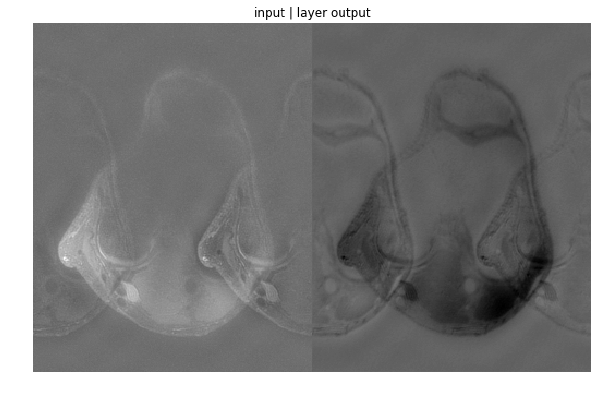

In [191]:
from utils import gen_interm_fun, plot_convs

# plot each kernel in a subplot with rows, cols
# p = plot_convs(model.layers[1], rows=5, cols=4)
# p.show()

# Create a function to produce output from intermediate layers
# handles some basic reshaping automatically
L1 = gen_interm_fun(inputs, model.layers[1])

# get a couple images
im = generator_test.x_transformed[0][160:162,:,:,:]

# evaluate the generated function
# produced shape = NHWC
outL1 = L1(im)

# plot the two, can change image number and channel/filter
image_num = 0
input_channel = 0
output_filter = 0
fig = plt.figure(figsize=(10, 10))
plt.imshow(np.hstack((im[image_num, :, :, input_channel], outL1[image_num, :, :, output_filter])), cmap='gray')
plt.title('input | layer output')
plt.axis('off')
plt.show()

<IPython.core.display.Javascript object>


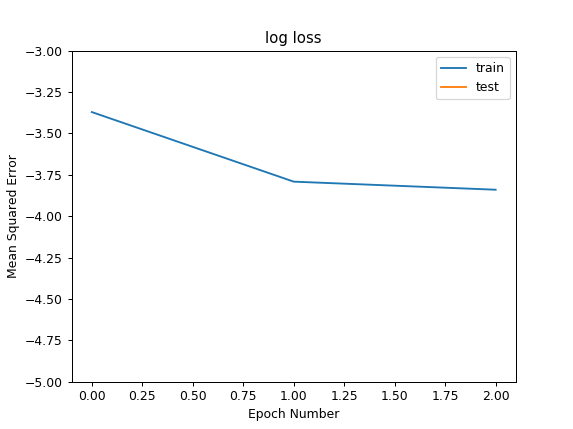

In [15]:
plt.plot(np.log10(history_callback.train_losses_epoch), label='train')
plt.plot(np.arange(0, len(history_callback.test_losses)) * history_callback.skip, np.log10(history_callback.test_losses), label='test')

plt.legend(['train', 'test'])

plt.title('log loss')
plt.ylim([-5, -3])
plt.xlabel('Epoch Number')
plt.ylabel('Mean Squared Error')
plt.show()


In [8]:
pred_test = model.predict(generator_test.x_transformed[0])
to_show_ref_test = generator_test.y_transformed[0]
to_show_us_test = generator_test.x_transformed[0]

pred_train = model.predict(generator_train.x_transformed[0])
to_show_ref_train  = generator_train.y_transformed[0]
to_show_us_train = generator_train.x_transformed[0]


In [9]:
def show_images(slice_to_show, pred, ref, us):
    im1 = pred[slice_to_show, :, :, 0]    
    im2 = ref[slice_to_show, :, :, 0]
    im3 = dd.sos(us[slice_to_show, :, :, :], axis=2)

    fig = plt.figure(figsize=(10, 10))
    plt.imshow(np.hstack((im1, im2, im3)), cmap='gray')
    plt.title('pred | ref | us')
    plt.axis('off')
    plt.show()

    fig = plt.figure(figsize=(5, 5))
    plt.imshow(abs(im2 - im1)* 10, cmap='gray', vmin=0, vmax=1)
    plt.title('diff x10')
    plt.axis('off')
    plt.show()

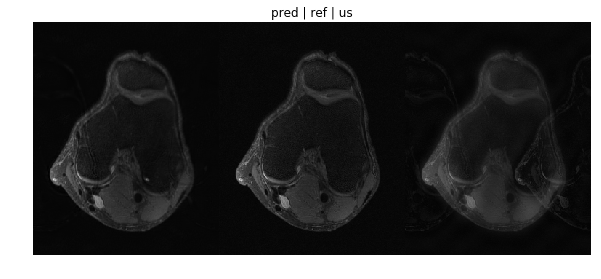

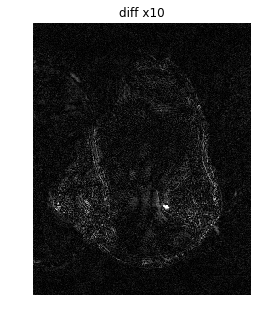

In [10]:
slice_to_show = 160
show_images(slice_to_show, pred_test, to_show_ref_test, to_show_us_test)

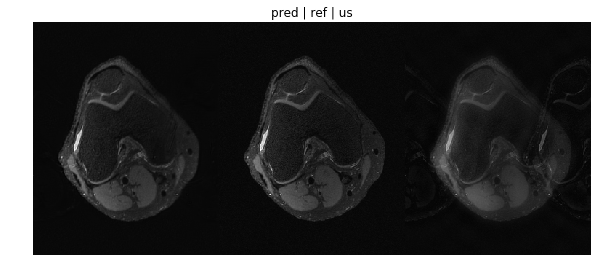

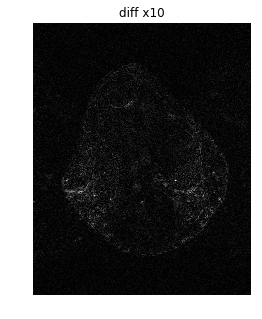

In [11]:
show_images(slice_to_show, pred_train, to_show_ref_train, to_show_us_train)

In [12]:
#model.save('models/very_small_unet_no_aug_kernel_1_3_no_pooling.h5')